### Some calculations prepared for the manuscript

In [1]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import plot_functions as pf
import pandas as pd
import xarray as xr
import seaborn as sns #sets up styles and gives us more plotting options
sns.set()

####  Porosity distribution calculations

In [2]:
def porosity(z, z_swi, phi_swi, phi_inf):
    """Calculates porosity on depth z according to depth at SWI (z_swi),
                  porosity at SWI (phi_swi),
              and porosity at 'infinite depth' layer )phi_inf"""
    k_phi = 0.04
    k = -(z-z_swi)/k_phi
    return (phi_inf+(phi_swi-phi_inf)*np.exp(k))

In [3]:
porosity(2.505, 2.5, 0.75, 0.25)

0.691248451292299

In [4]:
z = np.linspace(2.505, 2.595, 10)

In [5]:
phi_inf_array = np.arange(0.05, 0.36, 0.01)

In [6]:
phi_swi_array = np.arange(0.45, 0.86, 0.01)

which combinations of phi_swi and phi_inf match appoximately 0.43:

In [7]:
for phi_swi in phi_swi_array:
    for phi_inf in phi_inf_array:
        if (0.432 < sum(porosity(z, 2.5, phi_swi, phi_inf))/10 < 0.434):
            print(phi_swi, phi_inf)

0.6100000000000001 0.33
0.6300000000000001 0.32000000000000006
0.6800000000000002 0.29000000000000004
0.7000000000000002 0.28
0.7300000000000002 0.26000000000000006
0.7500000000000002 0.25000000000000006
0.8000000000000003 0.22000000000000003
0.8200000000000003 0.21000000000000002


#### Carbonates dissolution and precipitation estimation

Open a model output file with average kz dispersion coefficient. We will assume that precipitation is proportional to phytoplankton growth and dissolution is proportional to OM oxigen respiration

In [8]:
ds = xr.open_dataset('data/low_sulfate_reduction_rate/5_po75-25_di10e-9/water.nc')
alkflux_df = ds['B_C_Alk   _flux'].to_dataframe()
biogrow_df = ds['B_BIO_GrowthPhy'].to_dataframe()
omresp_df  = ds['B_BIO_DcPOC_O2'].to_dataframe()
alk_df     = ds['B_C_Alk'].to_dataframe()
alkflux_bottom = alkflux_df.groupby('z_faces').get_group(2.5)
omresp_bottom  = omresp_df.groupby('z').get_group(2.4749999046325684)
biogrow_surfac = biogrow_df.groupby('z').get_group(0.625)
alk_surface    = alk_df.groupby('z').get_group(0.625)
alk_surface_year = alk_surface.loc['2011-01-01':'2011-12-31']

In [9]:
year = (('2011-01-01','2011-01-31'), ('2011-02-01','2011-02-28'), ('2011-03-01','2011-03-31'), ('2011-04-01','2011-04-30'), 
        ('2011-05-01','2011-05-31'), ('2011-06-01','2011-06-30'), ('2011-07-01','2011-07-31'), ('2011-08-01','2011-08-31'),
        ('2011-09-01','2011-09-30'), ('2011-10-01','2011-10-31'), ('2011-11-01','2011-11-30'), ('2011-12-01','2011-12-31'))

In [10]:
year_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [11]:
year_acc_days = np.cumsum(year_days)
year_acc_days

array([ 31,  59,  90, 120, 151, 181, 212, 243, 273, 304, 334, 365])

In [12]:
alk_year_delta = []
alk_year = []
bio_year = []
res_year = []
for month in year:
    alk_delta_month = alk_surface.loc[month[0]:month[1]]
    alk_month = alkflux_bottom.loc[month[0]:month[1]]
    bio_month = biogrow_surfac.loc[month[0]:month[1]]
    res_month =  omresp_bottom.loc[month[0]:month[1]]
    alk_year_delta.append(alk_delta_month['B_C_Alk'][0])
    alk_year.append(alk_month['B_C_Alk   _flux'].mean())
    bio_year.append(bio_month['B_BIO_GrowthPhy'].mean())
    res_year.append(res_month['B_BIO_DcPOC_O2'].mean())

In [13]:
bio_year_quotas = np.array(bio_year)/sum(bio_year)
alk_year_quotas = np.array(alk_year)/sum(alk_year)
res_year_quotas = np.array(res_year)/sum(res_year)

According to Beukema the production/dissolution of CaCO$_3$ is approximately 1 M

In [14]:
caco3_precipitation = bio_year_quotas*1000/year_days #mM day-1
caco3_precipitation

array([0.06591641, 0.07615452, 0.3328146 , 4.60330779, 4.75019771,
       4.50845977, 4.89712587, 4.39132298, 4.06138277, 3.49720824,
       1.39452357, 0.15694502])

In [15]:
caco3_dissolution = res_year_quotas*1000/year_days #mM day-1
caco3_dissolution

array([0.71606399, 1.67373148, 1.92953585, 2.77043634, 4.34911983,
       5.93712477, 5.24333561, 3.73863469, 2.96444336, 1.73688719,
       1.25562211, 0.52212352])

In [16]:
ca_flux = caco3_dissolution - caco3_precipitation

In [17]:
ca_flux

array([ 0.65014758,  1.59757696,  1.59672124, -1.83287145, -0.40107788,
        1.42866501,  0.34620973, -0.65268829, -1.09693941, -1.76032105,
       -0.13890146,  0.3651785 ])

Calculate TA flux according to the depth of the Wadden Sea (2.5 m) and the fact that CaCO$_3$ participation/dissolution change TA by 2 moles per 1 mole of CaCO$_3$ precipitated/dissolved

In [18]:
ca_array = np.array(ca_flux)/2.5*2

In [19]:
ca_array

array([ 0.52011806,  1.27806157,  1.277377  , -1.46629716, -0.3208623 ,
        1.142932  ,  0.27696779, -0.52215064, -0.87755153, -1.40825684,
       -0.11112117,  0.2921428 ])

In [20]:
alk_surface_year = alk_surface_year.reset_index()
alk_array = np.array(alk_surface_year['B_C_Alk'])
alkflux_bottom_year = alkflux_bottom.loc['2011-01-01':'2011-12-31']
alkflux_bottom_year = alkflux_bottom_year.reset_index()

#### Calculate and plot a total increment of Ca$^{2+}$ concentration changes due to fluxes previously estimated

Calculate TA anomaly due to CaCO$_3$ changes:

In [21]:
calpart = np.zeros(365)
day = 0
last_entry = 0
for month, increment in zip(year_days, ca_array):
    temp = np.linspace(last_entry+increment, last_entry+increment*month, num=month)
    calpart[day:day+month] = temp
    last_entry = temp[-1]
    day += month

Monthly fluxes, see picture

In [22]:
caco3_dis = np.zeros(365)
day = 0
for month, increment in zip(year_days, caco3_dissolution):
    caco3_dis[day:day+month] = increment
    day += month

In [23]:
caco3_pre = np.zeros(365)
day = 0
for month, increment in zip(year_days, caco3_precipitation):
    caco3_pre[day:day+month] = increment
    day += month

In [24]:
result_array = alk_array + calpart

/home/shamil/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


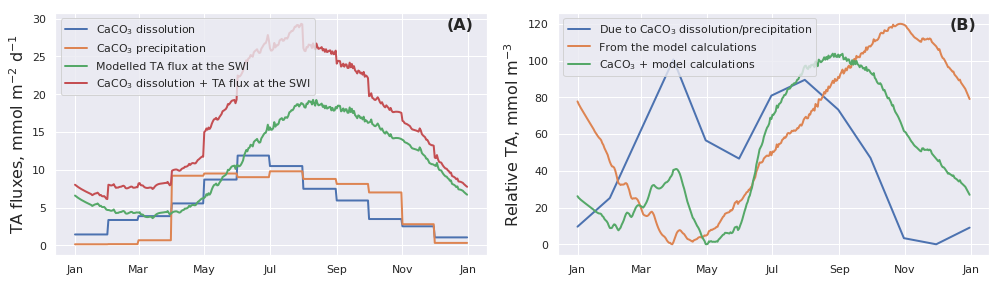

In [25]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(alk_surface_year['time'], caco3_dis*2, linewidth=2, label=r'CaCO$_3$ dissolution')
ax1.plot(alk_surface_year['time'], caco3_pre*2, linewidth=2, label=r'CaCO$_3$ precipitation')
ax1.plot(alk_surface_year['time'], alkflux_bottom_year['B_C_Alk   _flux'], linewidth=2, label=r'Modelled TA flux at the SWI')
ax1.plot(alk_surface_year['time'], caco3_dis*2+alkflux_bottom_year['B_C_Alk   _flux'], linewidth=2, 
         label=r'CaCO$_3$ dissolution + TA flux at the SWI')
ax1.set_ylabel('TA fluxes, mmol m$^{-2}$ d$^{-1}$', fontsize=16)
ax1.legend(loc='upper left')
ax1.grid(True)
ax = fig.add_subplot(1, 2, 2)
ax.plot(alk_surface_year['time'], calpart-calpart.min(), linewidth=2, label=r'Due to CaCO$_3$ dissolution/precipitation')
ax.plot(alk_surface_year['time'], alk_array-alk_array.min(), linewidth=2, label=r'From the model calculations')
ax.plot(alk_surface_year['time'], result_array - result_array.min(), linewidth=2, label=r'CaCO$_3$ + model calculations')
ax.set_ylabel('Relative TA, mmol m$^{-3}$', fontsize=16)
ax.legend(loc='upper left')
fntsz = 16
x_text = 0.97
y_text = 0.98
labels = ('(A)', '(B)')
for i,axis in enumerate((ax1,ax)):
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axis.text(x_text, y_text, labels[i], transform=axis.transAxes,
              fontsize=fntsz, fontweight='bold', va='top', ha='right')  
fig.tight_layout(pad=1)
plt.show()

In [26]:
ca_array

array([ 0.52011806,  1.27806157,  1.277377  , -1.46629716, -0.3208623 ,
        1.142932  ,  0.27696779, -0.52215064, -0.87755153, -1.40825684,
       -0.11112117,  0.2921428 ])

In [27]:
ca_array_monthly = ca_array*year_days
ca_array_monthly

array([ 16.12365996,  35.78572383,  39.59868686, -43.98891487,
        -9.94673145,  34.28796014,   8.58600134, -16.18666971,
       -26.32654583, -43.65596205,  -3.33363504,   9.05642681])

In [28]:
alk_array = np.array(alk_year_delta)

In [29]:
alk_array = alk_array - alk_array.min()
alk_array

array([ 75.07739 ,  40.81958 ,  16.935059,   0.      ,   2.230957,
        20.923096,  47.810547,  66.718994,  87.87427 , 105.78027 ,
       116.468506, 104.0957  ], dtype=float32)

#### Alkalinity fluxes compounds

In [30]:
ds = xr.open_dataset('data/low_sulfate_reduction_rate/5_po75-25_di10e-9/water.nc')
alkflux_df = ds['B_C_Alk   _flux'].to_dataframe()
nh4flux_df = ds['B_NUT_NH4 _flux'].to_dataframe()
no2flux_df = ds['B_NUT_NO2 _flux'].to_dataframe()
no3flux_df = ds['B_NUT_NO3 _flux'].to_dataframe()
po4flux_df = ds['B_NUT_PO4 _flux'].to_dataframe()
so4flux_df = ds['B_S_SO4   _flux'].to_dataframe()
alkflux_bottom = alkflux_df.groupby('z_faces').get_group(2.5)
nh4flux_bottom = nh4flux_df.groupby('z_faces').get_group(2.5)
no2flux_bottom = no2flux_df.groupby('z_faces').get_group(2.5)
no3flux_bottom = no3flux_df.groupby('z_faces').get_group(2.5)
po4flux_bottom = po4flux_df.groupby('z_faces').get_group(2.5)
so4flux_bottom = so4flux_df.groupby('z_faces').get_group(2.5)

In [31]:
year = (('2011-01-01','2011-01-31'), ('2011-02-01','2011-02-28'), ('2011-03-01','2011-03-31'), ('2011-04-01','2011-04-30'), 
        ('2011-05-01','2011-05-31'), ('2011-06-01','2011-06-30'), ('2011-07-01','2011-07-31'), ('2011-08-01','2011-08-31'),
        ('2011-09-01','2011-09-30'), ('2011-10-01','2011-10-31'), ('2011-11-01','2011-11-30'), ('2011-12-01','2011-12-31'))

In [32]:
year_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [33]:
alk_year = []
nh4_year = []
no2_year = []
no3_year = []
po4_year = []
so4_year = []
for month in year:
    alk_month = alkflux_bottom.loc[month[0]:month[1]]
    nh4_month = nh4flux_bottom.loc[month[0]:month[1]]
    no2_month = no2flux_bottom.loc[month[0]:month[1]]
    no3_month = no3flux_bottom.loc[month[0]:month[1]]
    po4_month = po4flux_bottom.loc[month[0]:month[1]]
    so4_month = so4flux_bottom.loc[month[0]:month[1]]
    alk_year.append(alk_month['B_C_Alk   _flux'].mean())
    nh4_year.append(nh4_month['B_NUT_NH4 _flux'].mean())
    no2_year.append(no2_month['B_NUT_NO2 _flux'].mean())
    no3_year.append(no3_month['B_NUT_NO3 _flux'].mean())
    po4_year.append(po4_month['B_NUT_PO4 _flux'].mean())
    so4_year.append(so4_month['B_S_SO4   _flux'].mean())

In [34]:
alk = np.array(alk_year)
nh4 = np.array(nh4_year)
no2 = np.array(no2_year)
no3 = np.array(no3_year)
po4 = np.array(po4_year)
so4 = np.array(so4_year)

In [35]:
all_components = nh4-no2-no3-po4-2*so4

In [36]:
nh4_quota = nh4/all_components
nh4_quota

array([0.12761769, 0.14015886, 0.14685221, 0.14037821, 0.14172562,
       0.11023074, 0.09720021, 0.08789225, 0.09185691, 0.09640039,
       0.1047076 , 0.11332254])

In [37]:
no2_quota = -no2/all_components
no2_quota

array([-0.00042005, -0.00080647, -0.001686  , -0.00230512,  0.00031057,
        0.00120826,  0.00013709,  0.00013442,  0.00033019,  0.00042988,
        0.00280258,  0.00182244])

In [38]:
no3_quota = -no3/all_components
no3_quota

array([0.07953435, 0.11249185, 0.13687219, 0.09518522, 0.0326903 ,
       0.00513885, 0.00082546, 0.00022191, 0.00035428, 0.00071845,
       0.00523538, 0.03760013])

In [39]:
po4_quota = -po4/all_components
po4_quota

array([-0.00453248, -0.00367439, -0.0027573 , -0.00452861, -0.00782811,
       -0.00693703, -0.00620746, -0.00565129, -0.0059348 , -0.00625626,
       -0.00679275, -0.00589359])

In [40]:
so4_quota = -so4*2/all_components
so4_quota

array([0.79780048, 0.75183015, 0.7207189 , 0.7712703 , 0.83310162,
       0.89035918, 0.90804471, 0.91740271, 0.91339342, 0.90870753,
       0.89404719, 0.85314848])

In [41]:
nh4_quota+no2_quota+no3_quota+po4_quota+so4_quota

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Alkalinity to reduced sulfur compounds fluxes fractions

In [152]:
ds1 = xr.open_dataset('data/low_sulfate_reduction_rate/2_po75-25_di1e-9/sediments.nc')
ds2 = xr.open_dataset('data/low_sulfate_reduction_rate/5_po75-25_di10e-9/sediments.nc')
ds3 = xr.open_dataset('data/low_sulfate_reduction_rate/10_po75-25_di35e-9/sediments.nc')

In [153]:
ds = ds1

alkflux_df = ds['B_C_Alk   _flux'].to_dataframe()
nh4flux_df = ds['B_NUT_NH4 _flux'].to_dataframe()
no2flux_df = ds['B_NUT_NO2 _flux'].to_dataframe()
no3flux_df = ds['B_NUT_NO3 _flux'].to_dataframe()
po4flux_df = ds['B_NUT_PO4 _flux'].to_dataframe()
so4flux_df = ds['B_S_SO4   _flux'].to_dataframe()
h2s__flux_df = ds['B_S_H2S   _flux'].to_dataframe()
s0___flux_df = ds['B_S_S0    _flux'].to_dataframe()
s2o3_flux_df = ds['B_S_S2O3  _flux'].to_dataframe()

alkflux_bottom = alkflux_df.groupby('z_faces').get_group(2.5)
nh4flux_bottom = nh4flux_df.groupby('z_faces').get_group(2.5)
no2flux_bottom = no2flux_df.groupby('z_faces').get_group(2.5)
no3flux_bottom = no3flux_df.groupby('z_faces').get_group(2.5)
po4flux_bottom = po4flux_df.groupby('z_faces').get_group(2.5)
so4flux_bottom = so4flux_df.groupby('z_faces').get_group(2.5)
h2sflux_bottom  = h2s__flux_df.groupby('z_faces').get_group(2.5)
s0flux_bottom   = s0___flux_df.groupby('z_faces').get_group(2.5)
s2o3flux_bottom = s2o3_flux_df.groupby('z_faces').get_group(2.5)

In [154]:
alkflux_df = alkflux_df.reset_index()
alkflux_df.z_faces[38]

2.5199999809265137

In [155]:
year = (('2011-01-01','2011-01-31'), ('2011-02-01','2011-02-28'), ('2011-03-01','2011-03-31'), ('2011-04-01','2011-04-30'), 
        ('2011-05-01','2011-05-31'), ('2011-06-01','2011-06-30'), ('2011-07-01','2011-07-31'), ('2011-08-01','2011-08-31'),
        ('2011-09-01','2011-09-30'), ('2011-10-01','2011-10-31'), ('2011-11-01','2011-11-30'), ('2011-12-01','2011-12-31'))

In [156]:
alk_year = []
nh4_year = []
no2_year = []
no3_year = []
po4_year = []
so4_year = []
h2s_year = []
s0_year = []
s2o3_year = []
for month in year:
    alk_month = alkflux_bottom.loc[month[0]:month[1]]
    nh4_month = nh4flux_bottom.loc[month[0]:month[1]]
    no2_month = no2flux_bottom.loc[month[0]:month[1]]
    no3_month = no3flux_bottom.loc[month[0]:month[1]]
    po4_month = po4flux_bottom.loc[month[0]:month[1]]
    so4_month = so4flux_bottom.loc[month[0]:month[1]]
    h2s_month = h2sflux_bottom.loc[month[0]:month[1]]
    s0_month = s0flux_bottom.loc[month[0]:month[1]]
    s2o3_month = s2o3flux_bottom.loc[month[0]:month[1]]
    alk_year.append(alk_month['B_C_Alk   _flux'].mean())
    nh4_year.append(nh4_month['B_NUT_NH4 _flux'].mean())
    no2_year.append(no2_month['B_NUT_NO2 _flux'].mean())
    no3_year.append(no3_month['B_NUT_NO3 _flux'].mean())
    po4_year.append(po4_month['B_NUT_PO4 _flux'].mean())
    so4_year.append(so4_month['B_S_SO4   _flux'].mean())
    h2s_year.append(h2s_month['B_S_H2S   _flux'].mean())
    s0_year.append(s0_month['B_S_S0    _flux'].mean())
    s2o3_year.append(s2o3_month['B_S_S2O3  _flux'].mean())

In [157]:
alk = np.array(alk_year)
nh4 = np.array(nh4_year)
no2 = np.array(no2_year)
no3 = np.array(no3_year)
po4 = np.array(po4_year)
so4 = np.array(so4_year)
h2s = np.array(h2s_year)
s0 = np.array(s0_year)
s2o3 = np.array(s2o3_year)

In [158]:
s_total = h2s + s0 + 2*s2o3

In [159]:
so4direct_quota = -2*so4

In [160]:
so4direct_quota

array([2.35925555, 2.19339037, 2.26728201, 2.48274851, 2.9621284 ,
       3.70206475, 4.37491894, 4.50708961, 4.17103577, 3.72517586,
       3.30154586, 2.82282472])

In [161]:
sulfurquota = s_total*2

In [162]:
sulfurquota

array([1.46716894, 1.36686411, 1.38448322, 1.57948667, 2.51684254,
       3.3318434 , 3.95644206, 4.06627689, 3.70018016, 3.05503491,
       2.44361214, 1.58050954])

In [163]:
sum(so4direct_quota)-sum(sulfurquota)

8.420715749263763

#### Advection TA change

In [26]:
ds = xr.open_dataset('data/advective_ta/1_10e-9/water.nc')

In [27]:
nh4ta_df = ds['TA_due_to_NH4'].to_dataframe()
no3ta_df = ds['TA_due_to_NO3'].to_dataframe()
po4ta_df = ds['TA_due_to_PO4'].to_dataframe()
so4ta_df = ds['TA_due_to_SO4'].to_dataframe()

In [28]:
year = (('2011-01-01','2011-01-31'), ('2011-02-01','2011-02-28'), ('2011-03-01','2011-03-31'), ('2011-04-01','2011-04-30'), 
        ('2011-05-01','2011-05-31'), ('2011-06-01','2011-06-30'), ('2011-07-01','2011-07-31'), ('2011-08-01','2011-08-31'),
        ('2011-09-01','2011-09-30'), ('2011-10-01','2011-10-31'), ('2011-11-01','2011-11-30'), ('2011-12-01','2011-12-31'))

In [29]:
nh4ta_year = []
no3ta_year = []
po4ta_year = []
so4ta_year = []
for month in year:
    nh4ta_month = nh4ta_df.loc[month[0]:month[1]]
    no3ta_month = no3ta_df.loc[month[0]:month[1]]
    po4ta_month = po4ta_df.loc[month[0]:month[1]]
    so4ta_month = so4ta_df.loc[month[0]:month[1]]
    nh4ta_year.append(nh4ta_month['TA_due_to_NH4'].sum())
    no3ta_year.append(no3ta_month['TA_due_to_NO3'].sum())
    po4ta_year.append(po4ta_month['TA_due_to_PO4'].sum())
    so4ta_year.append(so4ta_month['TA_due_to_SO4'].sum())

In [30]:
nh4ta = np.array(nh4ta_year)
no3ta = np.array(no3ta_year)
po4ta = np.array(po4ta_year)
so4ta = np.array(so4ta_year)
total = nh4ta+no3ta+po4ta+so4ta

here and further, units: mmol m$^{-2}$

In [31]:
nh4ta

array([ -57.724472,  -34.445347,  -28.580479,  -20.3435  ,  -58.750626,
        -46.986984,  -10.831028,  -11.092403,  -17.808699,  -40.038433,
       -134.03366 , -111.75628 ], dtype=float32)

In [32]:
no3ta

array([ -37.92114  ,  -30.888847 ,  -46.29358  , -207.19183  ,
        -95.33879  ,  -43.96344  ,  -39.63102  ,   -2.0348601,
         -4.0063643,   -5.9150224,  -52.22854  ,  -52.83625  ],
      dtype=float32)

In [33]:
po4ta

array([  2.1312208 ,   1.7261665 ,   0.18515338, -11.876101  ,
        -3.0395825 ,  -1.5026454 ,  -2.4156194 ,   0.24018678,
         0.84317803,   2.4042192 ,   6.0775366 ,   5.3426166 ],
      dtype=float32)

In [34]:
so4ta

array([ 59.228233 ,  45.42288  ,  39.374523 ,  18.765333 , -17.390285 ,
       -27.899496 , -39.025265 , -51.667156 , -41.036697 , -30.321947 ,
        -3.5132053,  36.002663 ], dtype=float32)

In [35]:
total

array([ -34.286163,  -18.185154,  -35.31438 , -220.6461  , -174.51929 ,
       -120.35257 ,  -91.90293 ,  -64.55423 ,  -62.008583,  -73.871185,
       -183.69788 , -123.247246], dtype=float32)

In [36]:
sum(so4ta)

-12.060421705245972

In [37]:
sum(total)

-1202.585708618164